Veri sütunları: Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Ke

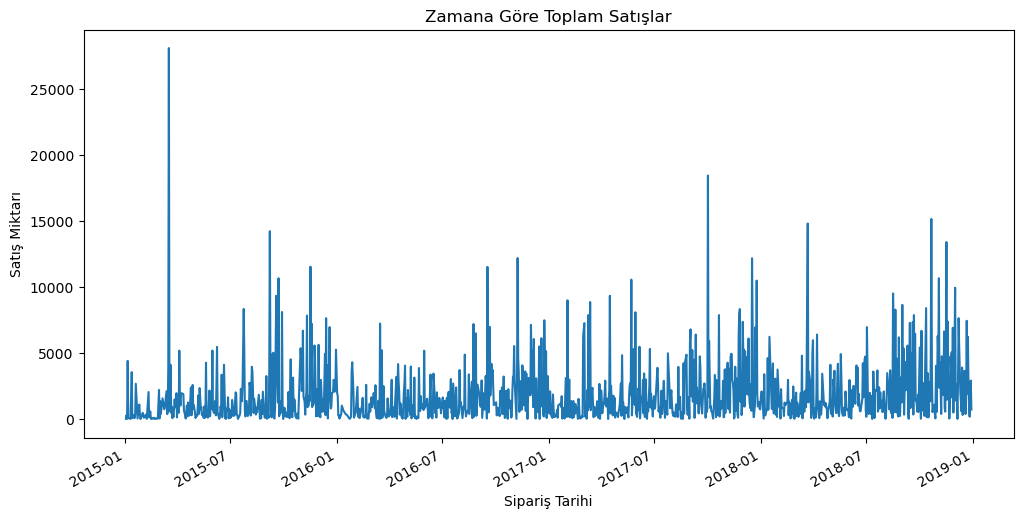

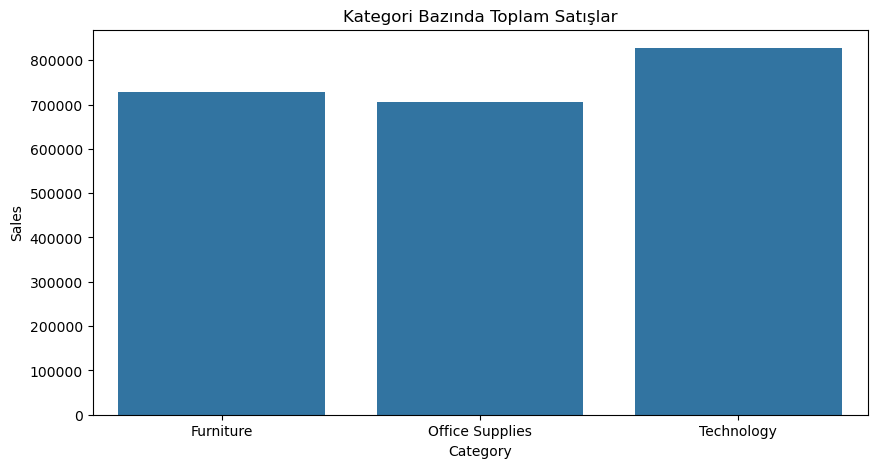

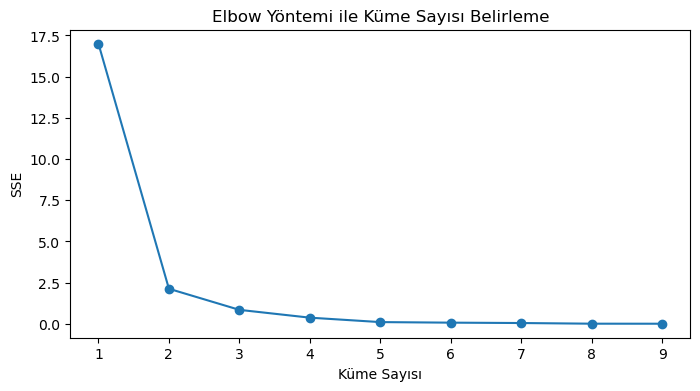

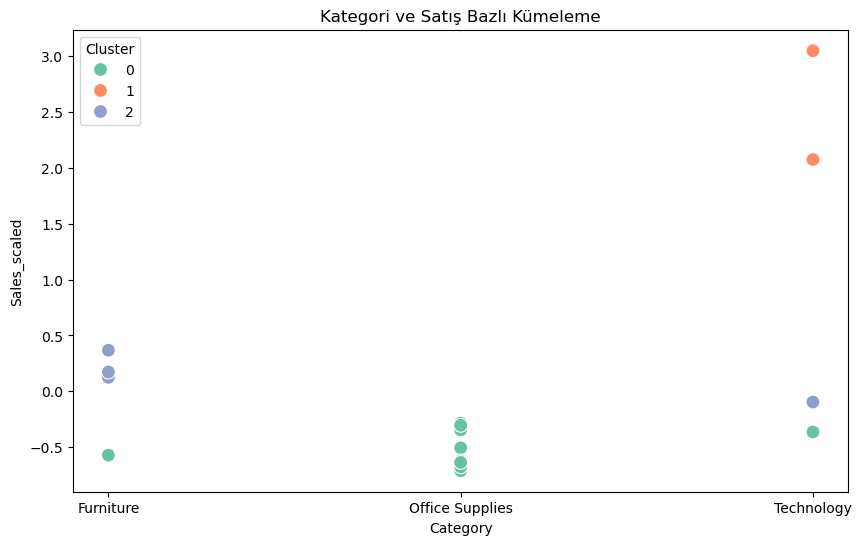


İşlem tamamlandı, cluster_results.csv dosyası oluşturuldu.


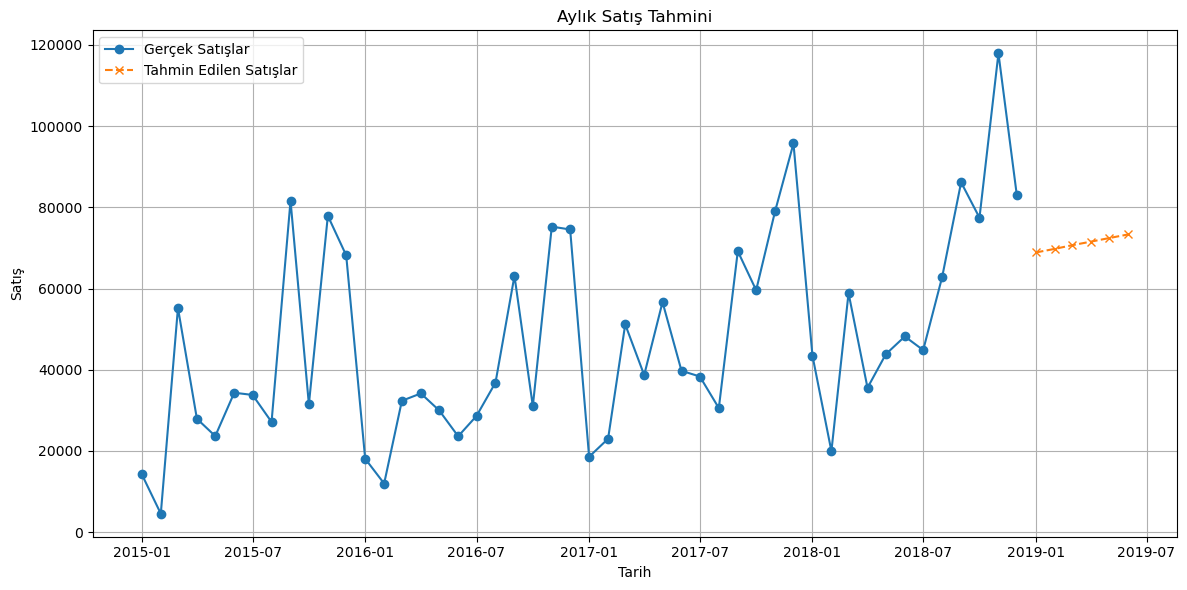

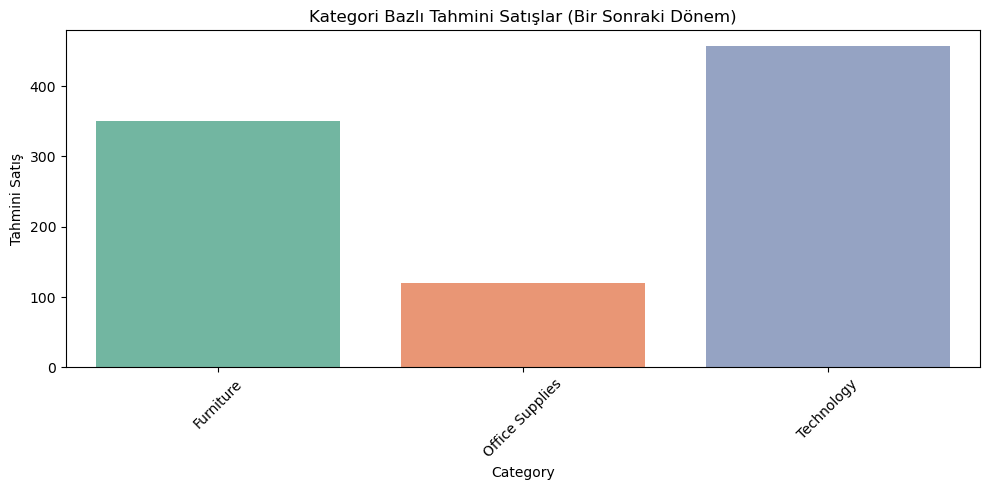

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 2. Veriyi yükle
df = pd.read_csv("C:/Users/Yasin/Desktop/train.csv")

# 3. Veri sütunlarını göster
print("Veri sütunları:", df.columns)

# 4. İlk 5 satırı göster (verinin yapısını anlamak için)
print(df.head())

# 5. Eksik veri kontrolü
print("\nEksik veri sayısı:\n", df.isnull().sum())

# 6. Tarih sütunlarını datetime formatına çevir
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

# 7. Temel istatistikler
print("\nTemel istatistikler:")
print(df.describe())

# 8. Kategorik sütunların eşsiz değer sayısı
print("\nKategori sütunlarındaki farklı değer sayısı:")
print(df[['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']].nunique())

# 9. Satışların zamana göre dağılımı (örnek)
plt.figure(figsize=(12,6))
df.groupby('Order Date')['Sales'].sum().plot()
plt.title("Zamana Göre Toplam Satışlar")
plt.ylabel("Satış Miktarı")
plt.xlabel("Sipariş Tarihi")
plt.savefig('zamanagoresatis.png')
plt.show()

# 10. Kategorilere göre toplam satışlar
plt.figure(figsize=(10,5))
sns.barplot(x='Category', y='Sales', data=df, estimator=sum, errorbar=None)
plt.title("Kategori Bazında Toplam Satışlar")
plt.savefig('kategorisatis.png')
plt.show()

# 11. Kümeleme için veri hazırlığı:
# Category ve Sub-Category bazında ortalama satışları gruplayalım
df_cluster = df.groupby(['Category', 'Sub-Category'])['Sales'].mean().reset_index()
df_cluster.rename(columns={'Sales': 'Avg_Sales'}, inplace=True)

# 12. Sayısal veriyi ölçeklendir
scaler = StandardScaler()
df_cluster['Sales_scaled'] = scaler.fit_transform(df_cluster[['Avg_Sales']])

# 13. Küme sayısı için Elbow yöntemi
sse = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster[['Sales_scaled']])
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1,10), sse, marker='o')
plt.xlabel('Küme Sayısı')
plt.ylabel('SSE')
plt.title('Elbow Yöntemi ile Küme Sayısı Belirleme')
plt.savefig('elbow.png')
plt.show()

# 14. Diyelim ki küme sayısı 3, KMeans uygula
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_cluster[['Sales_scaled']])

# 15. Sonuçları görselleştir
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cluster, x='Category', y='Sales_scaled', hue='Cluster', palette='Set2', s=100)
plt.title('Kategori ve Satış Bazlı Kümeleme')
plt.savefig('kategorisatisbazlikumeleme.png')
plt.show()
# 16. Küme sonuçlarını csv’ye kaydet
df_cluster.to_csv("cluster_results.csv", index=False)

print("\nİşlem tamamlandı, cluster_results.csv dosyası oluşturuldu.")

## 17. Zaman Serisi Analizi ile Satış Tahmini (Lineer Regresyon)

# 1. Sipariş tarihlerini ay bazında grupla
df['Order Month'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()
monthly_sales = df.groupby('Order Month')['Sales'].sum().reset_index()

# 2. X ve y hazırla
monthly_sales['Month_Num'] = range(len(monthly_sales))  # X = ay numarası
X = monthly_sales[['Month_Num']]
y = monthly_sales['Sales']

# 3. Model oluştur ve eğit
model = LinearRegression()
model.fit(X, y)

# 4. Tahmin yap (gelecek 6 ay)
future_months = pd.DataFrame({'Month_Num': range(len(monthly_sales), len(monthly_sales)+6)})
future_sales = model.predict(future_months)

# 5. Görselleştirme
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Order Month'], y, label='Gerçek Satışlar', marker='o')
plt.plot(pd.date_range(start=monthly_sales['Order Month'].iloc[-1] + pd.DateOffset(months=1), 
                       periods=6, freq='MS'),
         future_sales, label='Tahmin Edilen Satışlar', linestyle='--', marker='x')

plt.title("Aylık Satış Tahmini")
plt.xlabel("Tarih")
plt.ylabel("Satış")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ayliksatistahmini.png')
plt.show()
# Satış tahminleri
# 1. Tahmini satış verisi oluştur
df_tahmin = df.groupby('Category')['Sales'].mean().reset_index()
df_tahmin.columns = ['Category', 'Tahmini_Satis']

# 2. Grafik parametreleri
grup_kolonu = 'Category'
baslik = 'Kategori'

# 3. Görselleştirme
plt.figure(figsize=(10, 5))
sns.barplot(
    x=grup_kolonu,
    y='Tahmini_Satis',
    data=df_tahmin,
    hue=grup_kolonu,         # <--- eklendi
    palette='Set2',
    legend=False             # <--- gerek yok çünkü x ekseni etiketli
)
plt.title(f'{baslik} Bazlı Tahmini Satışlar (Bir Sonraki Dönem)')
plt.ylabel('Tahmini Satış')
plt.xlabel(grup_kolonu)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ayliksatis.png')
plt.show()